In [1]:
import glob
import os
import pathlib
import parse_um_atmos_results as pur
import plot_pandas_data as ppd
import plot_right_axis_time as pra
from convert_time import days_to_gregorian_years, gregorian_years_to_days
from numpy import linspace

In [2]:
um_atmos_archive_dir = pathlib.PurePath("../access-cm2/cm2_test/archive/")
work_dir_glob = os.path.join(um_atmos_archive_dir, "work.*.bench")
work_dir_list = glob.glob(work_dir_glob)

In [3]:
df_all = pur.parse_all(work_dir_list)
df = df_all[df_all["atm_cols"] != 28]
df1_all = df_all[df_all["omp_num_threads"] == 1]
df1 = df[df["omp_num_threads"] == 1]
df2 = df[df["omp_num_threads"] == 2]
o0 = lambda d: d[d["ocn_npes"] == 64]
o1 = lambda d: d[d["ocn_npes"] == 128]
o2 = lambda d: d[d["ocn_npes"] == 256]

In [4]:
df_all.shape

(72, 410)

In [5]:
xticks_ncpus = lambda d: d["ncpus"].sort_values().unique()
xticks_npes  = lambda d: d["npes"].sort_values().unique()

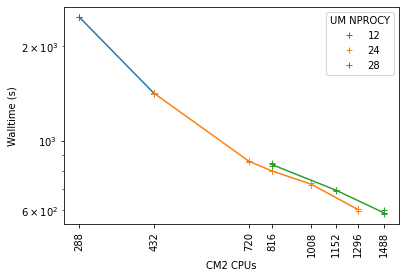

In [6]:
ppd.loglog_by_group("ncpus","walltime",
    by=["atm_cols"], 
    data=o1(df1_all),
    xlabel="CM2 CPUs",
    ylabel="Walltime (s)",
    xticks=xticks_ncpus(o1(df1_all)),               
    right_axis_fn=pra.no_right_axis,
    legend_title="UM NPROCY")

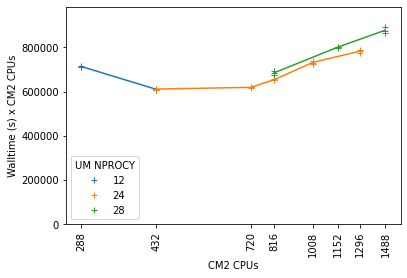

In [7]:
ppd.semilogx_by_group("ncpus","walltime * ncpus",
    by=["atm_cols"], 
    data=o1(df1_all),
    xlabel="CM2 CPUs",
    ylabel="Walltime (s) x CM2 CPUs",
    xticks=xticks_ncpus(o1(df1_all)),
    yticks=linspace(0,800000,5),
    right_axis_fn=pra.no_right_axis,
    legend_title="UM NPROCY")

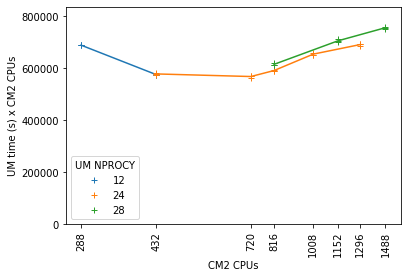

In [8]:
ppd.semilogx_by_group("ncpus","Atm_Step_4A (AS) * ncpus",
    by=["atm_cols"], 
    data=o1(df1_all),
    xlabel="CM2 CPUs",
    ylabel="UM time (s) x CM2 CPUs",
    xticks=xticks_ncpus(o1(df1_all)),
    yticks=linspace(0,800000,5),
    right_axis_fn=pra.no_right_axis,
    legend_title="UM NPROCY")

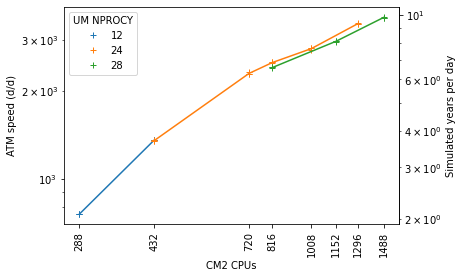

In [9]:
ppd.loglog_by_group("ncpus","Atm_Step_4A (AS) speed",
    by=["atm_cols"], 
    data=o1(df1_all),
    xlabel="CM2 CPUs",
    ylabel="ATM speed (d/d)",
    xticks=xticks_ncpus(o1(df1_all)),               
    right_axis_fn=pra.plot_right_axis_yd,
    legend_title="UM NPROCY")

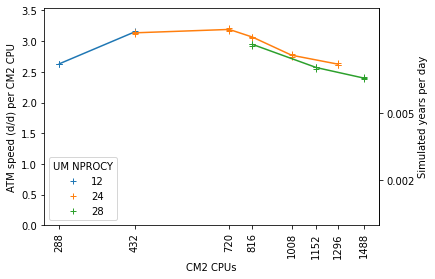

In [10]:
ppd.semilogx_by_group("ncpus","Atm_Step_4A (AS) * ncpus speed",
    by=["atm_cols"], 
    data=o1(df1_all),
    xlabel="CM2 CPUs",
    ylabel="ATM speed (d/d) per CM2 CPU",
    xticks=xticks_ncpus(o1(df1_all)),
    right_yticks=[0.002,0.005,0.01,0.02],
    right_axis_fn=pra.plot_right_axis_yd,
    legend_title="UM NPROCY")

In [11]:
def print_speed_per_cpu(speeds_per_cpu):
    print("CPUs d/d  Y/d")
    for ncpus in speeds_per_cpu:
        speed = speeds_per_cpu[ncpus]
        print(
            f"{ncpus:-4}",
            round(speed,2),
            round(days_to_gregorian_years(speed),5))

In [12]:
def derive_mean_speed_per_cpu(df, by="atm_cols"):
    mean_speed_per_cpu = dict()
    group_cols = df.groupby(by)
    for name, group in group_cols:
        group_by_ncpus = group.groupby("ncpus")
        ncpus_list = group_by_ncpus.groups.keys()
        mean_by_ncpus = group_by_ncpus.mean()
        mean_speeds = mean_by_ncpus["Atm_Step_4A (AS) speed"]
        mean_speed_per_cpu[name] = {
           ncpus: mean_speeds[ncpus]/ncpus for ncpus in ncpus_list}
    return mean_speed_per_cpu

In [13]:
mean_speed_per_cpu = derive_mean_speed_per_cpu(
    o1(df1_all),
    by="atm_cols")
    
print("Mean speed per CM2 CPU for UM NPROCY: 12")
print_speed_per_cpu(mean_speed_per_cpu[12])
print("Mean speed per CM2 CPU for UM NPROCY: 24")
print_speed_per_cpu(mean_speed_per_cpu[24])
print("Mean speed per CM2 CPU for UM NPROCY: 28")
print_speed_per_cpu(mean_speed_per_cpu[28])

speed_24x12_vs_12x24 = round(
    mean_speed_per_cpu[12][432]/mean_speed_per_cpu[24][432],3)
speed_28x24_vs_24x28=round(
    mean_speed_per_cpu[24][816]/mean_speed_per_cpu[28][816],3)

print("Speed at 24 x 12 vs 12 x 24")
print(speed_24x12_vs_12x24)
print("Speed at 28 x 24 vs 24 x 28")
print(speed_28x24_vs_24x28)

Mean speed per CM2 CPU for UM NPROCY: 12
CPUs d/d  Y/d
 288 2.63 0.00721
 432 3.15 0.00862
Mean speed per CM2 CPU for UM NPROCY: 24
CPUs d/d  Y/d
 432 3.14 0.00858
 720 3.19 0.00874
 816 3.07 0.0084
1008 2.77 0.00759
1296 2.62 0.00719
Mean speed per CM2 CPU for UM NPROCY: 28
CPUs d/d  Y/d
 816 2.95 0.00807
1152 2.57 0.00704
1488 2.4 0.00657
Speed at 24 x 12 vs 12 x 24
1.005
Speed at 28 x 24 vs 24 x 28
1.04


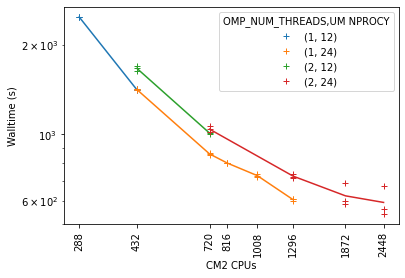

In [14]:
ppd.loglog_by_group("ncpus","walltime",
    by=["omp_num_threads","atm_cols"], 
    data=o1(df),
    xlabel="CM2 CPUs",
    ylabel="Walltime (s)",
    xticks=xticks_ncpus(o1(df)),               
    right_axis_fn=pra.no_right_axis,
    legend_title="OMP_NUM_THREADS,UM NPROCY")

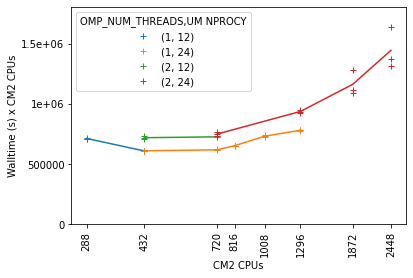

In [15]:
ppd.semilogx_by_group("ncpus","walltime * ncpus",
    by=["omp_num_threads","atm_cols"], 
    data=o1(df),
    xlabel="CM2 CPUs",
    ylabel="Walltime (s) x CM2 CPUs",
    xticks=xticks_ncpus(o1(df)),
    yticks=linspace(0,1500000,4),
    right_axis_fn=pra.no_right_axis,
    legend_title="OMP_NUM_THREADS,UM NPROCY")

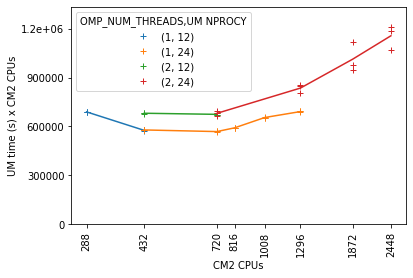

In [16]:
ppd.semilogx_by_group("ncpus","Atm_Step_4A (AS) * ncpus",
    by=["omp_num_threads","atm_cols"], 
    data=o1(df),
    xlabel="CM2 CPUs",
    ylabel="UM time (s) x CM2 CPUs",
    xticks=xticks_ncpus(o1(df)),
    yticks=linspace(0,1200000,5),
    right_axis_fn=pra.no_right_axis,
    legend_title="OMP_NUM_THREADS,UM NPROCY")

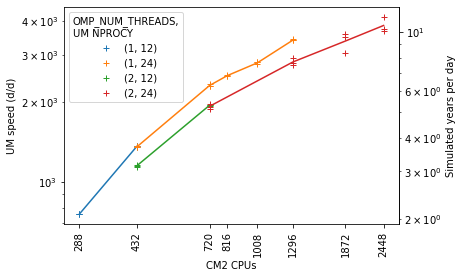

In [17]:
ppd.loglog_by_group("ncpus","Atm_Step_4A (AS) speed",
    by=["omp_num_threads","atm_cols"], 
    data=o1(df),
    xlabel="CM2 CPUs",
    ylabel="UM speed (d/d)",
    xticks=xticks_ncpus(o1(df)),             
    right_yticks=[0.5,1,2,5,10],
    right_axis_fn=pra.plot_right_axis_yd,
    legend_title="OMP_NUM_THREADS,\nUM NPROCY")

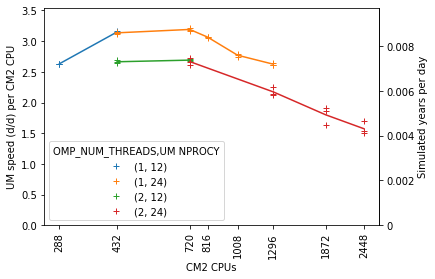

In [18]:
ppd.semilogx_by_group("ncpus","Atm_Step_4A (AS) * ncpus speed",
    by=["omp_num_threads","atm_cols"], 
    data=o1(df),
    xlabel="CM2 CPUs",
    ylabel="UM speed (d/d) per CM2 CPU",
    xticks=xticks_ncpus(o1(df)),               
    right_yticks=linspace(0,0.01,6),
    right_axis_fn=pra.plot_right_axis_yd,
    legend_title="OMP_NUM_THREADS,UM NPROCY")

In [19]:
mean_speed_per_cpu = derive_mean_speed_per_cpu(
    o1(df),
    by=["omp_num_threads","atm_cols"])
print("Mean speed per CM2 CPU for OMP_NUM_THREADS: 1, UM NPROCY: 12")
print_speed_per_cpu(mean_speed_per_cpu[(1,12)])
print("Mean speed per CM2 CPU for OMP_NUM_THREADS: 1, UM NPROCY: 24")
print_speed_per_cpu(mean_speed_per_cpu[(1,24)])
print("Mean speed per CM2 CPU for OMP_NUM_THREADS: 2, UM NPROCY: 12")
print_speed_per_cpu(mean_speed_per_cpu[(2,12)])
print("Mean speed per CM2 CPU for OMP_NUM_THREADS: 2, UM NPROCY: 24")
print_speed_per_cpu(mean_speed_per_cpu[(2,24)])

speed_omp1_vs_omp2 = dict()
speed_omp1_vs_omp2[432] = round(
    mean_speed_per_cpu[(1,12)][432]/mean_speed_per_cpu[(2,12)][432],2)
for ncpus in [720, 1296]:
    speed_omp1_vs_omp2[ncpus] = round(
        mean_speed_per_cpu[(1,24)][ncpus]/mean_speed_per_cpu[(2,24)][ncpus],2)
for ncpus in [432, 720, 1296]:
    print(f"Speed for 1 thread vs 2 threads for {ncpus} CPUs")
    print(speed_omp1_vs_omp2[ncpus])

Mean speed per CM2 CPU for OMP_NUM_THREADS: 1, UM NPROCY: 12
CPUs d/d  Y/d
 288 2.63 0.00721
 432 3.15 0.00862
Mean speed per CM2 CPU for OMP_NUM_THREADS: 1, UM NPROCY: 24
CPUs d/d  Y/d
 432 3.14 0.00858
 720 3.19 0.00874
 816 3.07 0.0084
1008 2.77 0.00759
1296 2.62 0.00719
Mean speed per CM2 CPU for OMP_NUM_THREADS: 2, UM NPROCY: 12
CPUs d/d  Y/d
 432 2.66 0.00729
 720 2.69 0.00737
Mean speed per CM2 CPU for OMP_NUM_THREADS: 2, UM NPROCY: 24
CPUs d/d  Y/d
 720 2.67 0.0073
1296 2.17 0.00595
1872 1.8 0.00493
2448 1.57 0.00431
Speed for 1 thread vs 2 threads for 432 CPUs
1.18
Speed for 1 thread vs 2 threads for 720 CPUs
1.2
Speed for 1 thread vs 2 threads for 1296 CPUs
1.21


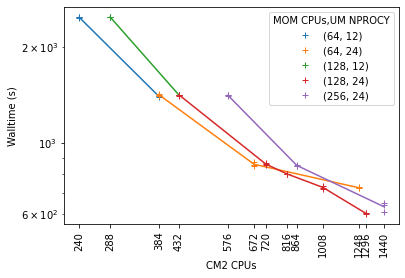

In [20]:
ppd.loglog_by_group("ncpus","walltime",
    by=["ocn_npes","atm_cols"], 
    data=df1,
    xlabel="CM2 CPUs",
    ylabel="Walltime (s)",
    xticks=xticks_ncpus(df1),               
    right_axis_fn=pra.no_right_axis,
    legend_title="MOM CPUs,UM NPROCY")

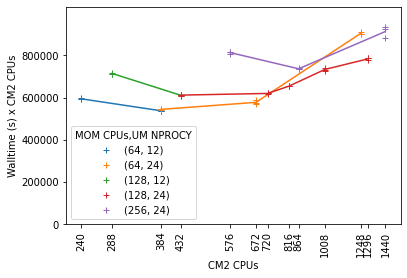

In [21]:
ppd.semilogx_by_group("ncpus","walltime * ncpus",
    by=["ocn_npes","atm_cols"], 
    data=df1,
    xlabel="CM2 CPUs",
    ylabel="Walltime (s) x CM2 CPUs",
    xticks=xticks_ncpus(df1),
    yticks=linspace(0,800000,5),
    right_axis_fn=pra.no_right_axis,
    legend_title="MOM CPUs,UM NPROCY")

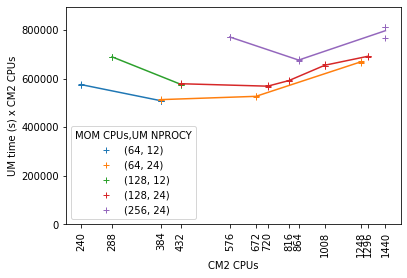

In [22]:
ppd.semilogx_by_group("ncpus","Atm_Step_4A (AS) * ncpus",
    by=["ocn_npes","atm_cols"], 
    data=df1,
    xlabel="CM2 CPUs",
    ylabel="UM time (s) x CM2 CPUs",
    xticks=xticks_ncpus(df1),
    yticks=linspace(0,800000,5),
    right_axis_fn=pra.no_right_axis,
    legend_title="MOM CPUs,UM NPROCY")

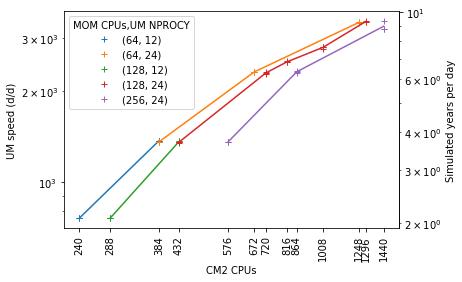

In [23]:
ppd.loglog_by_group("ncpus","Atm_Step_4A (AS) speed",
    by=["ocn_npes","atm_cols"], 
    data=df1,
    xlabel="CM2 CPUs",
    ylabel="UM speed (d/d)",
    xticks=xticks_ncpus(df1),
    right_axis_fn=pra.plot_right_axis_yd,
    legend_title="MOM CPUs,UM NPROCY")

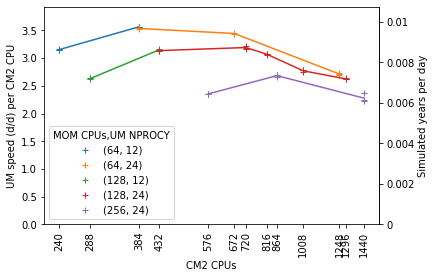

In [24]:
ppd.semilogx_by_group("ncpus","Atm_Step_4A (AS) * ncpus speed",
    by=["ocn_npes","atm_cols"], 
    data=df1,
    xlabel="CM2 CPUs",
    ylabel="UM speed (d/d) per CM2 CPU",
    xticks=xticks_ncpus(df1),               
    right_yticks=linspace(0,0.01,6),
    right_axis_fn=pra.plot_right_axis_yd,
    legend_title="MOM CPUs,UM NPROCY")

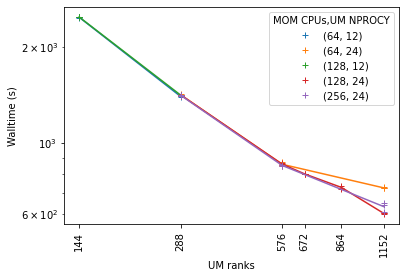

In [25]:
ppd.loglog_by_group("npes","walltime",
    by=["ocn_npes","atm_cols"], 
    data=df1,
    xlabel="UM ranks",
    ylabel="Walltime (s)",
    xticks=xticks_npes(df1),               
    right_axis_fn=pra.no_right_axis,
    legend_title="MOM CPUs,UM NPROCY")

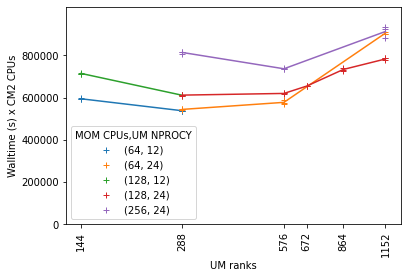

In [26]:
ppd.semilogx_by_group("npes","walltime * ncpus",
    by=["ocn_npes","atm_cols"], 
    data=df1,
    xlabel="UM ranks",
    ylabel="Walltime (s) x CM2 CPUs",
    xticks=xticks_npes(df1),
    yticks=linspace(0,800000,5),
    right_axis_fn=pra.no_right_axis,
    legend_title="MOM CPUs,UM NPROCY")

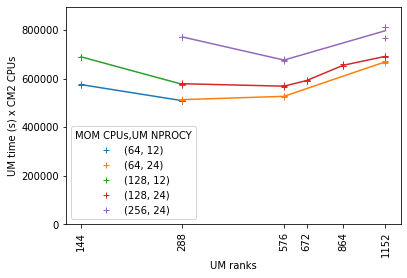

In [27]:
ppd.semilogx_by_group("npes","Atm_Step_4A (AS) * ncpus",
    by=["ocn_npes","atm_cols"], 
    data=df1,
    xlabel="UM ranks",
    ylabel="UM time (s) x CM2 CPUs",
    xticks=xticks_npes(df1),
    yticks=linspace(0,800000,5),
    right_axis_fn=pra.no_right_axis,
    legend_title="MOM CPUs,UM NPROCY")

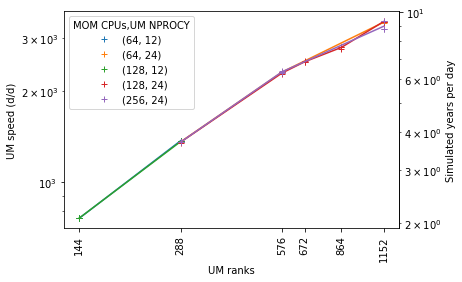

In [28]:
ppd.loglog_by_group("npes","Atm_Step_4A (AS) speed",
    by=["ocn_npes","atm_cols"], 
    data=df1,
    xlabel="UM ranks",
    ylabel="UM speed (d/d)",
    xticks=xticks_npes(df1),
    right_axis_fn=pra.plot_right_axis_yd,
    legend_title="MOM CPUs,UM NPROCY")

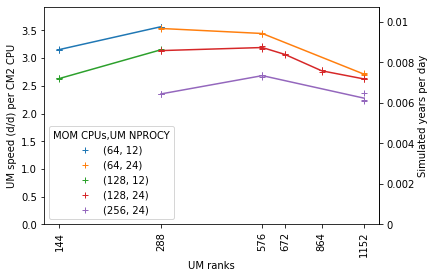

In [29]:
ppd.semilogx_by_group("npes","Atm_Step_4A (AS) * ncpus speed",
    by=["ocn_npes","atm_cols"], 
    data=df1,
    xlabel="UM ranks",
    ylabel="UM speed (d/d) per CM2 CPU",
    xticks=xticks_npes(df1),               
    right_yticks=linspace(0,0.01,6),
    right_axis_fn=pra.plot_right_axis_yd,
    legend_title="MOM CPUs,UM NPROCY")

In [30]:
series_speed_per_cpu = derive_mean_speed_per_cpu(
    df1,
    by=["ocn_npes","atm_cols","npes"])
mean_speed_per_cpu = (
    lambda key:
    list(series_speed_per_cpu[key].items())[0][1])
print("MOM CPUs UM NPROCY UM Ranks Speed per CM2 CPU")
for key in series_speed_per_cpu:
    speed = mean_speed_per_cpu(key)
    print(f"{key[0]:-6}     {key[1]:-6}    {key[2]:-6}    {speed:-5.3}")
print("MOM CPUs: 64 vs 128")
print("UM NPROCY: 12")
print("UM Ranks Speedup")
for npes in [144, 288]:
    print(f"{npes:-6}   {mean_speed_per_cpu((64,12,npes))/mean_speed_per_cpu((128,12,npes)):-5.3}")
print("UM NPROCY: 24")
print("UM Ranks Speedup")
for npes in [288, 576, 1152]:
    print(f"{npes:-6}   {mean_speed_per_cpu((64,24,npes))/mean_speed_per_cpu((128,24,npes)):-5.3}")
print("MOM CPUs: 128 vs 256")
print("UM NPROCY: 24")
print("UM Ranks Speedup")
for npes in [288, 576, 1152]:
    print(f"{npes:-6}   {mean_speed_per_cpu((128,24,npes))/mean_speed_per_cpu((256,24,npes)):-5.3}")

MOM CPUs UM NPROCY UM Ranks Speed per CM2 CPU
    64         12       144     3.15
    64         12       288     3.57
    64         24       288     3.53
    64         24       576     3.44
    64         24      1152     2.71
   128         12       144     2.63
   128         12       288     3.15
   128         24       288     3.14
   128         24       576     3.19
   128         24       672     3.07
   128         24       864     2.77
   128         24      1152     2.62
   256         24       288     2.35
   256         24       576     2.68
   256         24      1152     2.28
MOM CPUs: 64 vs 128
UM NPROCY: 12
UM Ranks Speedup
   144     1.2
   288    1.13
UM NPROCY: 24
UM Ranks Speedup
   288    1.13
   576    1.08
  1152    1.03
MOM CPUs: 128 vs 256
UM NPROCY: 24
UM Ranks Speedup
   288    1.33
   576    1.19
  1152    1.15


In [31]:
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [32]:
df_all.sort_values(["omp_num_threads","ocn_npes","npes","atm_cols"])

,service_units,ncpus,memory,jobfs,omp_num_threads,nbr_time_steps,seconds_per_time_step,exp_seconds,npes,atm_rows,atm_cols,ocn_npes,ocn_rows,ocn_cols,cpu_seconds,walltime,U_MODEL_4A,Atm_Step_4A (AS),AS Atmos_Phys1 (AP1),UKCA_MAIN1,AS Atmos_Phys2 (AP2),COSP,AP1 Radiation (AP1R),AS S-L Advect (AA),AS Solver,UKCA AEROSOL MODEL,AP2 Convection,AP1R LW Rad,AP1 Microphys (AP1M),EG_CORRECT_TRACERS,AP1M LS Rain,AA SL_Tracer,AP1R SW Rad,AP2 Boundary Layer,AA SL_Full_Wind,AP2 Implicit BL,UKCA CHEMISTRY MODEL,INITIAL,AA SL_Moisture,AP2 Explicit BL,AP1 G-wave drag,AA SL_Rho,EG_CORRECT_MOISTURE,AS End TStep Diags,AA SL_Thermo,TIMER,AS STASH,AP1M LS Cloud,AS Aerosol Modelling,AS Diffusion,AS Assimilation,AP1 NI_methox,AS Energy mass,AP1 Energy Correct.,AP2 Conv Eng Corr,AP1 Conv Eng Corr,AS IAU,AS Stochastic_Phys,cpu_seconds * ncpus,walltime * ncpus,U_MODEL_4A * ncpus,Atm_Step_4A (AS) * ncpus,AS Atmos_Phys1 (AP1) * ncpus,UKCA_MAIN1 * ncpus,AS Atmos_Phys2 (AP2) * ncpus,COSP * ncpus,AP1 Radiation (AP1R) * ncpus,AS S-L Advect (AA) * ncpus,AS Solver * ncpus,UKCA AEROSOL MODEL * ncpus,AP2 Convection * ncpus,AP1R LW Rad * ncpus,AP1 Microphys (AP1M) * ncpus,EG_CORRECT_TRACERS * ncpus,AP1M LS Rain * ncpus,AA SL_Tracer * ncpus,AP1R SW Rad * ncpus,AP2 Boundary Layer * ncpus,AA SL_Full_Wind * ncpus,AP2 Implicit BL * ncpus,UKCA CHEMISTRY MODEL * ncpus,INITIAL * ncpus,AA SL_Moisture * ncpus,AP2 Explicit BL * ncpus,AP1 G-wave drag * ncpus,AA SL_Rho * ncpus,EG_CORRECT_MOISTURE * ncpus,AS End TStep Diags * ncpus,AA SL_Thermo * ncpus,TIMER * ncpus,AS STASH * ncpus,AP1M LS Cloud * ncpus,AS Aerosol Modelling * ncpus,AS Diffusion * ncpus,AS Assimilation * ncpus,AP1 NI_methox * ncpus,AS Energy mass * ncpus,AP1 Energy Correct. * ncpus,AP2 Conv Eng Corr * ncpus,AP1 Conv Eng Corr * ncpus,AS IAU * ncpus,AS Stochastic_Phys * ncpus,cpu_seconds * npes,walltime * npes,U_MODEL_4A * npes,Atm_Step_4A (AS) * npes,AS Atmos_Phys1 (AP1) * npes,UKCA_MAIN1 * npes,AS Atmos_Phys2 (AP2) * npes,COSP * npes,AP1 Radiation (AP1R) * npes,AS S-L Advect (AA) * npes,AS Solver * npes,UKCA AEROSOL MODEL * npes,AP2 Convection * npes,AP1R LW Rad * npes,AP1 Microphys (AP1M) * npes,EG_CORRECT_TRACERS * npes,AP1M LS Rain * npes,AA SL_Tracer * npes,AP1R SW Rad * npes,AP2 Boundary Layer * npes,AA SL_Full_Wind * npes,AP2 Implicit BL * npes,UKCA CHEMISTRY MODEL * npes,INITIAL * npes,AA SL_Moisture * npes,AP2 Explicit BL * npes,AP1 G-wave drag * npes,AA SL_Rho * npes,EG_CORRECT_MOISTURE * npes,AS End TStep Diags * npes,AA SL_Thermo * npes,TIMER * npes,AS STASH * npes,AP1M LS Cloud * npes,AS Aerosol Modelling * npes,AS Diffusion * npes,AS Assimilation * npes,AP1 NI_methox * npes,AS Energy mass * npes,AP1 Energy Correct. * npes,AP2 Conv Eng Corr * npes,AP1 Conv Eng Corr * npes,AS IAU * npes,AS Stochastic_Phys * npes,cpu_seconds per time step,walltime per time step,U_MODEL_4A per time step,Atm_Step_4A (AS) per time step,AS Atmos_Phys1 (AP1) per time step,UKCA_MAIN1 per time step,AS Atmos_Phys2 (AP2) per time step,COSP per time step,AP1 Radiation (AP1R) per time step,AS S-L Advect (AA) per time step,AS Solver per time step,UKCA AEROSOL MODEL per time step,AP2 Convection per time step,AP1R LW Rad per time step,AP1 Microphys (AP1M) per time step,EG_CORRECT_TRACERS per time step,AP1M LS Rain per time step,AA SL_Tracer per time step,AP1R SW Rad per time step,AP2 Boundary Layer per time step,AA SL_Full_Wind per time step,AP2 Implicit BL per time step,UKCA CHEMISTRY MODEL per time step,INITIAL per time step,AA SL_Moisture per time step,AP2 Explicit BL per time step,AP1 G-wave drag per time step,AA SL_Rho per time step,EG_CORRECT_MOISTURE per time step,AS End TStep Diags per time step,AA SL_Thermo per time step,TIMER per time step,AS STASH per time step,AP1M LS Cloud per time step,AS Aerosol Modelling per time step,AS Diffusion per time step,AS Assimilation per time step,AP1 NI_methox per time step,AS Energy mass per time step,AP1 Energy Correct. per time step,AP2 Conv Eng Corr per time step,AP1 Conv Eng Corr per